# DS-1011 Assignment HW1
## Bag of N-Gram Document Classification

### Part 1 Tokenizing the IMDB data

In [ ]:
from os import listdir
from os.path import isfile, join

# Reading all of the negative and positive reviews into a tuple list
neg_path = 'aclImdb/train/neg'
pos_path = 'aclImdb/train/pos'
negative_files = [f for f in listdir(neg_path) if isfile(join(neg_path, f))]
postive_files = [f for f in listdir(pos_path) if isfile(join(pos_path, f))]

data = []
for neg_file in negative_files:
    with open(neg_path + '/' + neg_file, 'r') as f:
        review = f.read()
        data.append( (0,review) )
num_neg_reviews = len(data)
print('There are {} negative reviews.'.format(num_neg_reviews))
for pos_file in postive_files:
    with open(pos_path + '/' + pos_file, 'r') as f:
        review = f.read()
        data.append( (1,review) )
print('There are {} positive reviews.'.format(len(data) - num_neg_reviews))
print('Loaded {} examples'.format(str(len(data))))
print()
print(data[0])
print()
print(data[len(data)-1])        

In [ ]:
import random
# Avoid any ordering bias by randomly shuffling the list
print([target[0] for target in data[0:10]])
random.Random(4).shuffle(data)
print([target[0] for target in data[0:10]])

In [ ]:
# Create a validation set from the training data
train_split = 20000

train_data = data[:train_split]
train_x = [data[1] for data in train_data]
train_y = [data[0] for data in train_data]

val_data = data[train_split:]
val_x = [data[1] for data in val_data]
val_y = [data[0] for data in val_data]

print('{} training samples'.format(len(train_data)))
print([target for target in train_y[0:10]])
print('{} validation samples'.format(len(val_data)))
print([target for target in val_y[0:10]])
print(len(val_y))

In [ ]:
# Assess performance on the test set
# Reading all of the negative and positive reviews into a tuple list
neg_path = 'aclImdb/test/neg'
pos_path = 'aclImdb/test/pos'
negative_files = [f for f in listdir(neg_path) if isfile(join(neg_path, f))]
postive_files = [f for f in listdir(pos_path) if isfile(join(pos_path, f))]

test_data = []
for neg_file in negative_files:
    with open(neg_path + '/' + neg_file, 'r') as f:
        review = f.read()
        test_data.append( (0,review) )
num_neg_reviews = len(test_data)
print('There are {} negative test reviews.'.format(num_neg_reviews))
for pos_file in postive_files:
    with open(pos_path + '/' + pos_file, 'r') as f:
        review = f.read()
        test_data.append( (1,review) )
print('There are {} positive test reviews.'.format(len(test_data) - num_neg_reviews))
print('Loaded {} examples'.format(str(len(test_data))))
print()
print(test_data[0])
print()
print(test_data[len(test_data)-1])   

In [ ]:
test_x = [data_t[1] for data_t in test_data]
test_y = [data_t[0] for data_t in test_data]

print('{} test samples'.format(len(test_data)))
print([target for target in test_y[0:10]])

In [ ]:
# Tokenize the reviews
import nltk
import os
import pickle as pkl
import spacy
import string
import time

from collections import Counter
from tqdm import tqdm_notebook

class NGramBuilder(object):
    """
    Class which enables hyperparameter searching over the word tokenization process
    """
    # save index 0 for unk and 1 for pad
    PAD_IDX = 0
    UNK_IDX = 1
    def __init__(self, max_vocab_size, n_gram_size, all_permutations=True):
        """
        all_permutations: if True then that means if you picked an n-gram size of 3, then you would have
        all the 1-gram and 2-gram combos included as well.
        """
        self.tokenizer = spacy.load('en_core_web_sm')
        self.punctuations = string.punctuation
        self.max_vocab_size = max_vocab_size
        self.n_gram_size = n_gram_size
        self.all_permutations = all_permutations
        self.vocabulary_tokens = []
        self.id2token = None
        self.token2id = None
    
    def _lower_case_remove_punc(self, parsed):
        return [token.text.lower() for token in parsed if (token.text not in self.punctuations)]

    def tokenize_dataset(self, dataset, training=False):
        token_dataset = []
        start_time = time.time()
        for sample in tqdm_notebook(self.tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=4)):
            tokens = self._lower_case_remove_punc(sample)
            all_tokens = []
            n_grams = nltk.ngrams(tokens, self.n_gram_size)
            all_tokens = [' '.join(grams) for grams in n_grams]
            token_dataset.append(all_tokens)
            if training:
                self.vocabulary_tokens += all_tokens
        print("--- {} seconds ---".format(time.time() - start_time))
        return token_dataset
    
    def build_vocab(self):
        # Returns:
        # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
        # token2id: dictionary where keys represent tokens and corresponding values represent indices
        token_counter = Counter(self.vocabulary_tokens)
        vocab, count = zip(*token_counter.most_common(self.max_vocab_size))
        self.id2token = list(vocab)
        self.token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
        self.id2token = ['<pad>', '<unk>'] + self.id2token
        self.token2id['<pad>'] = self.PAD_IDX 
        self.token2id['<unk>'] = self.UNK_IDX
        self.vocabulary_tokens = None
    
    def token2index_dataset(self, tokens_data):
        indices_data = []
        for tokens in tokens_data:
            index_list = [self.token2id[token] if token in self.token2id else self.UNK_IDX for token in tokens]
            indices_data.append(index_list)
        return indices_data
    
    def get_indexed_dataset_from_training_text_vector(self, text_vector, overwrite=True):
        data_tokens = None
        training_pickle_path = "train_data_tokens_{}_{}.p".format(self.n_gram_size, self.max_vocab_size)
        id2token_path = "id2token_{}_{}.p".format(self.n_gram_size, self.max_vocab_size)
        token2id_path = "token2id_{}_{}.p".format(self.n_gram_size, self.max_vocab_size)

        train_data_tokens = None
        if os.path.isfile(training_pickle_path) and os.path.isfile(id2token_path) and not overwrite:
            print("Loading existing training token pickle file and vocabulary.")
            train_data_tokens = pkl.load(open(training_pickle_path, "rb"))
            self.id2token = pkl.load(open(id2token_path, "rb"))
            self.token2id = pkl.load(open(token2id_path, "rb"))
        elif not overwrite:
            raise ValueError('File not found for training')
        else:
            train_data_tokens = self.tokenize_dataset(text_vector, training=True)
#             pkl.dump(train_data_tokens, open(training_pickle_path, "wb"))
            self.build_vocab()
#             pkl.dump(self.id2token, open(id2token_path, "wb"))
#             pkl.dump(self.token2id, open(token2id_path, "wb"))

        train_data_indices = self.token2index_dataset(train_data_tokens)
        return train_data_indices
        
    
    def get_indexed_dataset_from_val_and_test_vector(self, val_vector, test_vector, overwrite=True):
        if not self.id2token:
            raise ValueError('Must load training set prior to validationa and test sets')
        data_tokens = None
        
        val_data_tokens = None
        test_data_tokens = None
        val_pickle_path = "val_data_tokens_{}_{}.p".format(self.n_gram_size, self.max_vocab_size)
        test_pickle_path = "test_data_tokens_{}_{}.p".format(self.n_gram_size, self.max_vocab_size)
        
        if os.path.isfile(val_pickle_path) and os.path.isfile(test_pickle_path) and not overwrite:
            print("Loading existing training token pickle file and vocabulary.")
            val_data_tokens = pkl.load(open(val_pickle_path, "rb"))
            test_data_tokens = pkl.load(open(test_pickle_path, "rb"))
        elif not overwrite:
            raise ValueError('File not found for validation or testing')
        else:
            val_data_tokens = self.tokenize_dataset(val_vector)
#             pkl.dump(val_data_tokens, open(val_pickle_path, "wb"))
            test_data_tokens = self.tokenize_dataset(test_vector)
#             pkl.dump(test_data_tokens, open(test_pickle_path, "wb"))
            
        val_data_indices = self.token2index_dataset(val_data_tokens)
        test_data_indices = self.token2index_dataset(test_data_tokens)
        return val_data_indices, test_data_indices


In [ ]:
from multiprocessing import Process

def multi_write(vocab_size, n):
    print("Building bag of words for {} vocab size and {} gram(s)".format(vocab_size, n))
    ngram_builder = NGramBuilder(max_vocab_size=vocab_size, n_gram_size=n, all_permutations=True) 
    train_data_indices = ngram_builder.get_indexed_dataset_from_training_text_vector(train_x)
    val_data_indices, test_data_indices = ngram_builder.get_indexed_dataset_from_val_and_test_vector(val_x, test_x)

    training_pickle_path = "train_index_tokens_{}_{}.p".format(n, vocab_size)
    val_pickle_path = "val_index_tokens_{}_{}.p".format(n, vocab_size)
    test_pickle_path = "test_index_tokens_{}_{}.p".format(n, vocab_size)
    print('Writing the pickles')
    pkl.dump(train_data_indices, open(training_pickle_path, "wb"))
    pkl.dump(val_data_indices, open(val_pickle_path, "wb"))
    pkl.dump(test_data_indices, open(test_pickle_path, "wb"))

vocab_sizes = [10000, 20000, 40000, 80000]
n_sizes = [1,2,3]
# vocab_sizes = [100]
# n_sizes = [1]
for n in n_sizes:
    processes = []
    for vocab_size in vocab_sizes:
        p = Process(target=multi_write, args=(vocab_size,n,))
        processes.append(p)
        p.start()

    for one_process in processes:
        one_process.join()

    print("Done!")


In [ ]:
# Ad-hoc tokenization generation
multi_write(60000, 2)

In [ ]:
#print(ngram_builder.vocabulary_tokens[0:100])
print()
print(train_data_indices[2])
print()
print(len(ngram_builder.id2token))
#print(len(ngram_builder.vocabulary_tokens))
print(ngram_builder.id2token[-100:])
print()
print([ngram_builder.token2id[k] for k in sorted(ngram_builder.token2id.keys())[:2]])
print([v for v in list(ngram_builder.token2id.values())[:2]])

print(len(train_data_indices))
print(len(train_y))

print(len(val_data_indices))
print(len(val_y))

### Part 2 Initial Hyperparameter Tuning

In [ ]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class ImdbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of imdb review tokens 
        @param target_list: list of imdb review targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader


# for i, (data, lengths, labels) in enumerate(train_loader):
#    print(data)
#    print(labels)
#    break

In [ ]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding (use at least 100 to 500 and keep increasing)
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out


In [ ]:
class HyperParameterTuner(object):
    """
    This class will help tune hyperparameters
    """
    def __init__(self,model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        
    def get_indices_for_hyperparamters(self, n_gram_size, max_vocab_size):
        print("Retrieving bag of words for {} vocab size and {} gram(s)".format(max_vocab_size, n_gram_size))
        training_pickle_path = "train_index_tokens_{}_{}.p".format(n_gram_size, max_vocab_size)
        val_pickle_path = "val_index_tokens_{}_{}.p".format(n_gram_size, max_vocab_size)
        test_pickle_path = "test_index_tokens_{}_{}.p".format(n_gram_size, max_vocab_size)
        train_data_indices = pkl.load(open(training_pickle_path, "rb"))
        val_data_indices = pkl.load(open(val_pickle_path, "rb"))
        test_data_indices = pkl.load(open(test_pickle_path, "rb"))
        return train_data_indices, val_data_indices, test_data_indices

    # Function for testing the model
    def test_model2(self, loader, record_classifications=False):
        """
        Help function that tests the model's performance on a dataset
        @param: loader - data loader for the dataset to test against
        """
        correct = 0
        total = 0
        self.model.eval()
        for data, lengths, labels in loader:
            data_batch, length_batch, label_batch = data, lengths, labels
            outputs = F.softmax(self.model(data_batch, length_batch), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]
            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        return (100 * correct / total)

    def train_and_validate_model(self, num_epochs, train_loader, val_loader):
        accuracies = []
        losses = []
        for epoch in range(num_epochs):
            running_loss = 0.0
            last_accuracy = 0
            for i, (data, lengths, labels) in enumerate(train_loader):
                self.model.train()
                data_batch, length_batch, label_batch = data, lengths, labels
                self.optimizer.zero_grad()
                outputs = self.model(data_batch, length_batch)
                loss = self.criterion(outputs, label_batch)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                # validate every 100 iterations
                if i > 0 and i % 100 == 0:
                    # validate
                    print('loss: ' + str(running_loss))
                    val_acc = self.test_model2(val_loader)
                    last_accuracy = val_acc
                    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                               epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            losses.append(running_loss)
            accuracies.append(last_accuracy)
        print( (accuracies, losses))
        return accuracies, losses


In [ ]:
# Find out how many epics should be run
# DONT RERUN ME - RUN THE BELOW

def run_model(max_vocab_size,n):
    tuning_record = []
    learning_rates = [0.01]
#     learning_rates = [0.01]
    emb_dim = 100
    model = BagOfWords(max_vocab_size + 2, emb_dim)
    for learning_rate in learning_rates:
        print("learning rate: "+ str(learning_rate))
        # Criterion and Optimizer
        criterion = torch.nn.CrossEntropyLoss() 
        # criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        hpt = HyperParameterTuner(model, criterion, optimizer)
        train_data_indices, val_data_indices, test_data_indices = hpt.get_indices_for_hyperparamters(n, max_vocab_size)

        BATCH_SIZE = 32
        print(len(train_y))
        print(len(train_data_indices))
        train_dataset = ImdbDataset(train_data_indices, train_y)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=imdb_collate_func,
                                                   shuffle=True)

        val_dataset = ImdbDataset(val_data_indices, val_y)
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=imdb_collate_func,
                                                   shuffle=True)

        num_epochs = 20 # number epoch to train
        accuracies, losses = hpt.train_and_validate_model(num_epochs, train_loader, val_loader)
        accuracies_all = (max_vocab_size, n, learning_rate, accuracies, losses)
        tuning_record.append(accuracies_all)
        print(accuracies_all)
    pkl.dump(tuning_record, open("tuning_record_long_epic_{}_{}.p".format(n, max_vocab_size), "wb"))

# run_model(80000,3)
    
# vocab_sizes = [10000, 20000, 40000, 80000]
# n_sizes = [2]
# for n in n_sizes:
#     processes = []
#     for vocab_size in vocab_sizes:
#         p = Process(target=run_model, args=(vocab_size,n,))
#         processes.append(p)
#         p.start()

#     for one_process in processes:
#         one_process.join()

#     print("Done!")


In [ ]:
# RUN ME!!! NOT ABOVE - WAIT FOR ABOVE TO FINISH

def run_model(max_vocab_size,n):
    tuning_record = []
    learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
#     learning_rates = [0.01]
    emb_dim = 100
    model = BagOfWords(max_vocab_size + 2, emb_dim)
    for learning_rate in learning_rates:
        print("learning rate: "+ str(learning_rate))
        # Criterion and Optimizer
        criterion = torch.nn.CrossEntropyLoss() 
        # criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        hpt = HyperParameterTuner(model, criterion, optimizer)
        train_data_indices, val_data_indices, test_data_indices = hpt.get_indices_for_hyperparamters(n, max_vocab_size)

        BATCH_SIZE = 32
        train_dataset = ImdbDataset(train_data_indices, train_y)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=imdb_collate_func,
                                                   shuffle=True)

        val_dataset = ImdbDataset(val_data_indices, val_y)
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=imdb_collate_func,
                                                   shuffle=True)

        num_epochs = 5 # number epoch to train
        accuracies, losses = hpt.train_and_validate_model(num_epochs, train_loader, val_loader)
        accuracies_all = (max_vocab_size, n, learning_rate, accuracies, losses)
        tuning_record.append(accuracies_all)
        print(accuracies_all)
    pkl.dump(tuning_record, open("tuning_record_{}_{}.p".format(n, max_vocab_size), "wb"))

# run_model(80000,3)
    
# vocab_sizes = [10000, 20000, 40000, 80000]
# n_sizes = [1,2,3]
# for n in n_sizes:
#     processes = []
#     for vocab_size in vocab_sizes:
#         p = Process(target=run_model, args=(vocab_size,n,))
#         processes.append(p)
#         p.start()

#     for one_process in processes:
#         one_process.join()

#     print("Done!")


In [ ]:
tuning_record2 = pkl.load(open("tuning_record.p", "rb"))
print(str(tuning_record2))

In [ ]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline
#plt.rcParams['figure.figsize'] = 12, 12

val_predicted_y = []
actual_y = []

for data, lengths, labels in val_loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        print(model(data_batch, length_batch))
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        print(outputs[:,0])
#         val_predicted_y += (outputs.max(1, keepdim=True)[1]).squeeze(1).tolist()
        val_predicted_y += outputs[:,0].squeeze(0).tolist()
        actual_y += labels.tolist()
        print(val_predicted_y)
        print(actual_y)
        break

fpr_log_ct, tpr_log_ct, threshold_log_ct = roc_curve(actual_y, val_predicted_y)
roc_auc_log_ct = auc(fpr_log_ct, tpr_log_ct)
print(roc_auc_log_ct)

plt.title('Comparing ROC Across Different Vocabulary Sizes')
plt.plot(fpr_log_ct, tpr_log_ct, 'b', label = 'AUC for vocab size of 10,000 = %0.4f' % roc_auc_log_ct)
# plt.plot(fpr_nb_ct, tpr_nb_ct, 'b', label = 'AUC for vocab size of 20,000 = %0.4f' % roc_auc_nb_ct, color='purple')
# plt.plot(fpr_log_tfidf, tpr_log_tfidf, 'b', label = 'AUC for vocab size of 40,000 = %0.4f' % roc_auc_log_tfidf, color='green')
# plt.plot(fpr_nb_tfidf, tpr_nb_tfidf, 'b', label = 'AUC for vocab size of 80,000 = %0.4f' % roc_auc_nb_tfidf, color='orange')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Part 3 Analyzing The Hyperparameter Tuning Output

In [1]:
import pickle as pkl
tuning_record1 = pkl.load(open("tuning_record_long_epic_2_10000.p", "rb"))
tuning_record2 = pkl.load(open("tuning_record_long_epic_2_20000.p", "rb"))
tuning_record3 = pkl.load(open("tuning_record_long_epic_2_40000.p", "rb"))
tuning_record4 = pkl.load(open("tuning_record_long_epic_2_80000.p", "rb"))

print(str(tuning_record2))

[(20000, 2, 0.01, [85.24, 84.42, 82.16, 82.88, 82.48, 82.18, 82.34, 82.6, 82.56, 82.44, 82.4, 82.36, 82.38, 82.28, 82.28, 82.22, 82.12, 82.14, 82.1, 82.02], [275.2626093029976, 124.39769503846765, 60.75663270428777, 28.24606984294951, 9.990154033526778, 3.1930819991976023, 1.0672514345496893, 0.4932357408106327, 0.2894637659192085, 0.1962379589676857, 0.1364305317401886, 0.09588363021612167, 0.06790123879909515, 0.04828180372714996, 0.03435192257165909, 0.02443981170654297, 0.017557375133037567, 0.012486197054386139, 0.008922010660171509, 0.00644703209400177])]


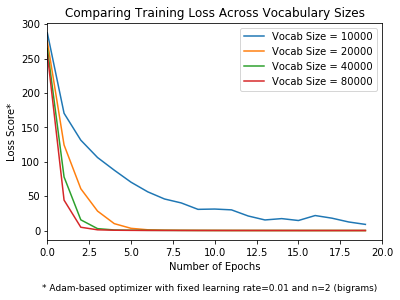

In [2]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

plt.plot(list(range(0, 20)), tuning_record1[0][4], label="Vocab Size = 10000") 
plt.plot(list(range(0, 20)), tuning_record2[0][4], label="Vocab Size = 20000") 
plt.plot(list(range(0, 20)), tuning_record3[0][4], label="Vocab Size = 40000") 
plt.plot(list(range(0, 20)), tuning_record4[0][4], label="Vocab Size = 80000") 

plt.title('Comparing Training Loss Across Vocabulary Sizes')
plt.legend(loc = 'upper right')
# plt.ylim([0, 15])
plt.xlim([0, 20])

plt.ylabel('Loss Score*')
plt.xlabel('Number of Epochs')
txt="* Adam-based optimizer with fixed learning rate=0.01 and n=2 (bigrams)"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.show() 

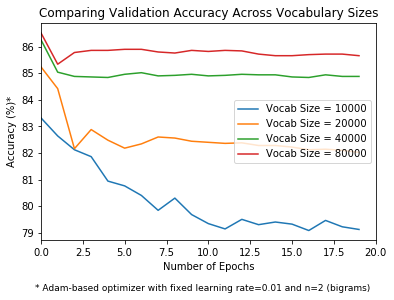

In [3]:
plt.plot(list(range(0, 20)), tuning_record1[0][3], label="Vocab Size = 10000") 
plt.plot(list(range(0, 20)), tuning_record2[0][3], label="Vocab Size = 20000") 
plt.plot(list(range(0, 20)), tuning_record3[0][3], label="Vocab Size = 40000") 
plt.plot(list(range(0, 20)), tuning_record4[0][3], label="Vocab Size = 80000") 

plt.title('Comparing Validation Accuracy Across Vocabulary Sizes')
plt.legend(loc = 'center right')
# plt.ylim([0, 15])
plt.xlim([0, 20])
txt="* Adam-based optimizer with fixed learning rate=0.01 and n=2 (bigrams)"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.ylabel('Accuracy (%)*')
plt.xlabel('Number of Epochs')
plt.show() 

In [ ]:
tuning_record1 = pkl.load(open("tuning_record_1_10000.p", "rb"))
tuning_record2 = pkl.load(open("tuning_record_1_20000.p", "rb"))
tuning_record3 = pkl.load(open("tuning_record_1_40000.p", "rb"))
tuning_record4 = pkl.load(open("tuning_record_1_80000.p", "rb"))
print(tuning_record1)


In [ ]:
tuning_records = [tuning_record1,tuning_record2,tuning_record3,tuning_record4]
for record in tuning_record1:
    print(record)
    plt.plot(list(range(1, 6)), record[3], label="Learning Rate= {}".format(record[2]))

plt.title('Comparing Validation Accuracy Across Learning Rates')
plt.legend(loc = 'upper right')
# plt.ylim([0, 15])
plt.xlim([1, 5])
txt="* Adam-based optimizer with fixed vocab_size=10000 and n=1 (monograms)"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.ylabel('Accuracy (%)*')
plt.xlabel('Number of Epochs')
plt.show() 

for record in tuning_record4:
    print(record)
    plt.plot(list(range(1, 6)), record[3], label="Learning Rates= {}".format(record[2]))

plt.title('Comparing Validation Accuracy Across Learning Rate')
plt.legend(loc = 'lower left')
# plt.ylim([0, 15])
plt.xlim([1, 5])
txt="* Adam-based optimizer with fixed vocab_size=80000 and n=1 (monograms)"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.ylabel('Accuracy (%)*')
plt.xlabel('Number of Epochs')
plt.show() 

In [ ]:
tuning_record1 = pkl.load(open("tuning_record_2_10000.p", "rb"))
tuning_record2 = pkl.load(open("tuning_record_2_20000.p", "rb"))
tuning_record3 = pkl.load(open("tuning_record_2_40000.p", "rb"))
tuning_record4 = pkl.load(open("tuning_record_2_80000.p", "rb"))
print(tuning_record1)

In [ ]:
for record in tuning_record1:
    print(record)
    plt.plot(list(range(1, 6)), record[3], label="Learning Rate= {}".format(record[2]))

plt.title('Comparing Validation Accuracy Across Learning Rates')
plt.legend(loc = 'upper right')
# plt.ylim([0, 15])
plt.xlim([1, 5])
txt="* Adam-based optimizer with fixed vocab_size=10000 and n=2 (bigrams)"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.ylabel('Accuracy (%)*')
plt.xlabel('Number of Epochs')
plt.show() 

for record in tuning_record4:
    print(record)
    plt.plot(list(range(1, 6)), record[3], label="Learning Rates= {}".format(record[2]))

plt.title('Comparing Validation Accuracy Across Learning Rate')
plt.legend(loc = 'lower left')
# plt.ylim([0, 15])
plt.xlim([1, 5])
txt="* Adam-based optimizer with fixed vocab_size=80000 and n=2 (bigrams)"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.ylabel('Accuracy (%)*')
plt.xlabel('Number of Epochs')
plt.show() 

In [ ]:
records = pkl.load(open("tuning_record_3_10000.p", "rb"))
for record in records:
    print(record)
    plt.plot(list(range(1, 6)), record[3], label="Learning Rate= {}".format(record[2]))

plt.title('Comparing Validation Accuracy Across Learning Rates')
plt.legend(loc = 'lower right')
# plt.ylim([0, 15])
plt.xlim([1, 5])
txt="* Adam-based optimizer with fixed vocab_size=10000 and n=3 (trigrams)"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.ylabel('Accuracy (%)*')
plt.xlabel('Number of Epochs')
plt.show() 

In [ ]:
vocab_sizes = [10000, 20000, 40000, 80000]
n_sizes = [1,2,3]
for n in n_sizes:
    for vocab_size in vocab_sizes:
        tuning_record = pkl.load(open("tuning_record_{}_{}.p".format(n,vocab_size), "rb"))
        learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
        for i, rate in enumerate(learning_rates):
            print(n)
            print(vocab_size)
            print(rate)
            print(tuning_record[i][2])
            print()
            print(tuning_record[i][3][4])
            print()



### Part 4 Testing The Optimizers

In [ ]:
learning_rate = 0.01
emb_dim = 100
vocab_size = 60000
model = BagOfWords(vocab_size + 2, emb_dim)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
hpt = HyperParameterTuner(model, criterion, optimizer)
train_data_indices, val_data_indices, test_data_indices = hpt.get_indices_for_hyperparamters(2, vocab_size)
BATCH_SIZE = 32
train_dataset = ImdbDataset(train_data_indices, train_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = ImdbDataset(val_data_indices, val_y)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)
hpt.train_and_validate_model(5, train_loader, val_loader)


### Part 5 Assess Best Model Performance On The Test Dataset

In [ ]:
# test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))
print(len(test_data_indices))
print(len(test_y))
test_dataset = ImdbDataset(test_data_indices, test_y)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

In [ ]:
print ("After training for {} epochs".format(5))
print ("Val Acc {}".format(hpt.test_model2(val_loader)))
print ("Test Acc {}".format(hpt.test_model2(test_loader)))

In [ ]:
fpr_log_ct, tpr_log_ct, threshold_log_ct = roc_curve(Y_test, preds_log_ct)
roc_auc_log_ct = auc(fpr_log_ct, tpr_log_ct)

plt.title('ROC For Test Set With Best Model')
plt.plot(fpr_nb_tfidf, tpr_nb_tfidf, 'b', label = 'AUC for tfidf Naive Bayes = %0.4f' % roc_auc_nb_tfidf, color='orange')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()